In [1]:
# Importing libraries

import ccxt
import json
import time
import random
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import datetime
import os

In [ ]:
import ccxt
import pandas as pd
import os

def filter_high_liquidity_pairs(exchange, min_volume=50000000, top_n=100):
    """Fetches the top N most liquid USDT pairs dynamically based on 24h trading volume."""
    try:
        markets = exchange.load_markets()
        volume_data = []

        for s, data in markets.items():
            if "USDT" in s:
                quote_volume = float(data.get("info", {}).get("quoteVolume", 0))
                volume_data.append((s, quote_volume))

        # Sort pairs by highest volume & filter out low-liquidity pairs
        high_liquidity_pairs = sorted(volume_data, key=lambda x: x[1], reverse=True)
        high_liquidity_pairs = [pair[0] for pair in high_liquidity_pairs if pair[1] >= min_volume]

        return high_liquidity_pairs[:top_n]  # Return only the top N pairs
    except Exception as e:
        print(f"⚠️ Error fetching high-liquidity pairs: {e}")
        return []



def get_exchange_info(exchange_name, min_volume=50000000):
    """Fetch relevant trading information for a given exchange, filtering for high-liquidity USDT pairs."""
    try:
        exchange = getattr(ccxt, exchange_name)()

        # Fetch API rate limits
        rate_limits = {
            "rate_limit": exchange.rateLimit,
            "has_fetch_ticker": exchange.has["fetchTicker"],
            "has_fetch_balance": exchange.has["fetchBalance"],
            "has_fetch_order": exchange.has["fetchOrder"]
        }

        # Fetch trading fees (Spot)
        try:
            fees = exchange.fetch_trading_fees()
            trading_fees = {
                "maker_fee": fees.get("maker", 0.001),  # Default to 0.1% if unknown
                "taker_fee": fees.get("taker", 0.001)
            }
        except Exception:
            trading_fees = {"maker_fee": "Unknown", "taker_fee": "Unknown"}

        # Fetch supported symbols (Only high-liquidity USDT pairs)
        try:
            high_liquidity_symbols = filter_high_liquidity_pairs(exchange, min_volume)
        except Exception:
            high_liquidity_symbols = []

        return {
            "Exchange": exchange_name,
            "API Rate Limits": rate_limits,
            "Trading Fees": trading_fees,
            "Supported Symbols": high_liquidity_symbols
        }

    except Exception as e:
        return {"Error": f"⚠️ Could not retrieve data for {exchange_name}: {e}"}


def compare_fees_and_spreads(exchange1_name, exchange2_name, min_volume=50000000):
    """Compare trading fees, average cost, and spread for high-liquidity USDT trading pairs between two exchanges."""
    if exchange1_name == exchange2_name:
        raise ValueError("❌ Both exchanges are the same. Please enter two different exchanges.")

    if not hasattr(ccxt, exchange1_name) or not hasattr(ccxt, exchange2_name):
        raise ValueError("❌ One or both exchanges are not listed in CCXT. Check your inputs.")

    # Fetch exchange information
    exchange1_info = get_exchange_info(exchange1_name, min_volume)
    exchange2_info = get_exchange_info(exchange2_name, min_volume)

    # Find common trading symbols (Only high-liquidity USDT pairs)
    symbols1 = set(exchange1_info.get("Supported Symbols", []))
    symbols2 = set(exchange2_info.get("Supported Symbols", []))
    common_symbols = list(symbols1 & symbols2)

    print(f"✅ Found {len(common_symbols)} high-liquidity trading pairs between {exchange1_name} and {exchange2_name}")

    if not common_symbols:
        raise ValueError(f"❌ No common **high-liquidity** USDT trading pairs found between {exchange1_name} and {exchange2_name}.")

    # Connect to exchanges
    exchange1 = getattr(ccxt, exchange1_name)()
    exchange2 = getattr(ccxt, exchange2_name)()

    results = []

    for symbol in common_symbols:
        try:
            # Fetch latest prices
            price1 = exchange1.fetch_ticker(symbol)["last"]
            price2 = exchange2.fetch_ticker(symbol)["last"]

            # Calculate spread percentage
            spread = abs(price1 - price2) / ((price1 + price2) / 2) * 100

            # Get trading fees
            fee1 = exchange1_info["Trading Fees"]
            fee2 = exchange2_info["Trading Fees"]

            results.append({
                "Symbol": symbol,
                "Exchange 1": exchange1_name,
                "Exchange 2": exchange2_name,
                "Price 1": price1,
                "Price 2": price2,
                "Average Price": (price1 + price2) / 2,
                "Spread (%)": spread,
                "Exchange 1 Maker Fee": fee1["maker_fee"],
                "Exchange 1 Taker Fee": fee1["taker_fee"],
                "Exchange 2 Maker Fee": fee2["maker_fee"],
                "Exchange 2 Taker Fee": fee2["taker_fee"]
            })

        except Exception as e:
            print(f"⚠️ Error fetching data for {symbol}: {e}")
            continue  # Skip symbols that cause errors

    # Convert to a DataFrame for better visualization
    df = pd.DataFrame(results)
    
    if df.empty:
        raise ValueError("❌ No valid **high-liquidity** trading pairs with price data found.")

    return df


# Example Usage (Run only if results.csv does not exist)
if not os.path.exists('results.csv'):
    try:
        exchange1 = "binance"
        exchange2 = "bybit"
        result_df = compare_fees_and_spreads(exchange1, exchange2)

        # Display the results
        display(result_df)

    except ValueError as e:
        print(e)
else:
    result_df = pd.read_csv('results.csv')


✅ Found 0 high-liquidity trading pairs between binance and bybit
❌ No common **high-liquidity** USDT trading pairs found between binance and bybit.


In [3]:
# result_df.to_csv('results.csv', index=False)

In [4]:
def calculate_potential_profit(results_df, trade_amount):
    """Adds a column to the results dataframe for potential profit given a trade amount."""
    
    # Ensure the DataFrame is not empty
    if results_df.empty:
        raise ValueError("❌ No valid trading pairs found.")

    # Function to calculate profit for each row
    def compute_profit(row):
        buy_price = min(row["Price 1"], row["Price 2"])
        sell_price = max(row["Price 1"], row["Price 2"])

        # Identify the exchanges for buy/sell
        if buy_price == row["Price 1"]:
            buy_exchange = row["Exchange 1"]
            sell_exchange = row["Exchange 2"]
            buy_fee = row["Exchange 1 Taker Fee"]
            sell_fee = row["Exchange 2 Taker Fee"]
        else:
            buy_exchange = row["Exchange 2"]
            sell_exchange = row["Exchange 1"]
            buy_fee = row["Exchange 2 Taker Fee"]
            sell_fee = row["Exchange 1 Taker Fee"]
        
        # Default fees to 0.001 if they are unknown
        buy_fee = float(buy_fee) if isinstance(buy_fee, (int, float)) else 0.001
        sell_fee = float(sell_fee) if isinstance(sell_fee, (int, float)) else 0.001

        # Calculate BTC amount that can be bought with the trade amount
        btc_amount = trade_amount / buy_price

        # Calculate fees
        buy_fee_cost = buy_price * btc_amount * buy_fee
        sell_fee_cost = sell_price * btc_amount * sell_fee
        total_fees = buy_fee_cost + sell_fee_cost

        # Calculate raw profit (before fees)
        raw_profit = (sell_price - buy_price) * btc_amount

        # Calculate final profit (after fees)
        final_profit = raw_profit - total_fees

        return final_profit

    # Apply profit calculation to each row
    results_df["Potential Profit ($)"] = results_df.apply(compute_profit, axis=1)

    return results_df


# Example Usage:
trade_amount = 10  # Input trade amount in USD
results_df = calculate_potential_profit(result_df, trade_amount)

# Display the updated DataFrame
display(results_df)


NameError: name 'result_df' is not defined

📊 Binance: $0.00 | Bybit: $0.00 | Spread: $0.00
⏳ Simulating Arbitrage Trade... (Time: 0.32s)
✅ Trade 10: Bought on Bybit ($0.00), Sold on Binance ($0.00)
💰 Simulated Profit: $-0.02 | Total Profit: $-0.16 | Fees: $0.02



,Trade #,Buy Exchange,Sell Exchange,Buy Price,Sell Price,Spread,Profit,Fees,Trade Time
0,1,Bybit,Binance,0.001922,0.001923,1.000000e-06,-0.014797,0.02,0.221737
1,2,Bybit,Binance,0.001922,0.001923,1.000000e-06,-0.014797,0.02,0.495935
2,3,Bybit,Binance,0.001922,0.001923,1.000000e-06,-0.014797,0.02,0.288462
3,4,Bybit,Binance,0.001922,0.001923,1.000000e-06,-0.014797,0.02,0.381048
4,5,Bybit,Binance,0.001922,0.001923,1.000000e-06,-0.014797,0.02,0.401108
5,6,Bybit,Binance,0.001922,0.001923,1.000000e-06,-0.014797,0.02,0.419398
6,7,Bybit,Binance,0.001922,0.001923,1.000000e-06,-0.014797,0.02,0.445631
7,8,Bybit,Binance,0.001922,0.001923,1.000000e-06,-0.014797,0.02,0.484364
8,9,Bybit,Binance,0.001922,0.001922,0.000000e+00,-0.020000,0.02,0.491529
9,10,Bybit,Binance,0.001922,0.001922,0.000000e+00,-0.020000,0.02,0.319062


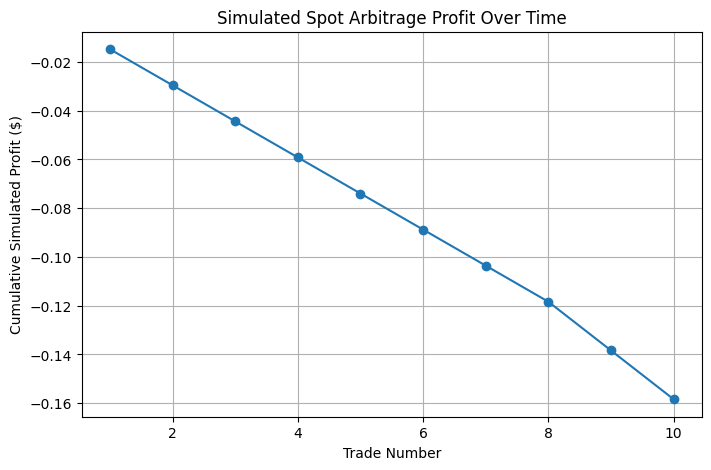

In [ ]:
# --- Load API Keys from JSON (for fetching prices only) ---
with open("keys.json", "r") as file:
    keys = json.load(file)

# --- Connect to Binance & Bybit Spot Trading (Read-Only for Paper Trading) ---
binance = ccxt.binance({'options': {'defaultType': 'spot'}, 'enableRateLimit': True})
bybit = ccxt.bybit({'options': {'defaultType': 'spot'}})

print("✅ Connected to Binance & Bybit (Paper Trading Mode)")

# --- Trading Parameters ---
initial_balance = 10000  # USD balance
trade_amount = 10  # Simulated trade size in USD
spread_threshold = 0.5  # Minimum spread for arbitrage
trade_fee = 0.001  # 0.1% per trade (simulated)
min_trade_time = 0.2  # Min execution time (sec)
max_trade_time = 0.5  # Max execution time (sec)

# --- Simulated Account Balances ---
balance_binance = initial_balance / 2
balance_bybit = initial_balance / 2
profit = 0
num_trades = 0
trade_log = []

# --- Fetch Spot Prices ---
def get_spot_price(exchange, symbol="SLP/USDT"):
    try:
        ticker = exchange.fetch_ticker(symbol)
        return ticker["last"]
    except Exception as e:
        print(f"⚠️ Error fetching price from {exchange.name}: {e}")
        return None

# --- Simulated Arbitrage Trading ---
for _ in range(10):  # Run arbitrage 10 times (Adjust as needed)
    binance_price = get_spot_price(binance)
    bybit_price = get_spot_price(bybit)

    if binance_price is None or bybit_price is None:
        continue

    spread = abs(binance_price - bybit_price)
    clear_output(wait=True)
    print(f"📊 Binance: ${binance_price:.2f} | Bybit: ${bybit_price:.2f} | Spread: ${spread:.2f}")

    if binance_price < bybit_price:
        buy_exchange, sell_exchange = "Binance", "Bybit"
        buy_price, sell_price = binance_price, bybit_price
        if balance_binance < trade_amount:
            print("⚠️ Not enough balance on Binance for trade.")
            continue
        balance_binance -= trade_amount
        balance_bybit += trade_amount
    else:
        buy_exchange, sell_exchange = "Bybit", "Binance"
        buy_price, sell_price = bybit_price, binance_price
        if balance_bybit < trade_amount:
            print("⚠️ Not enough balance on Bybit for trade.")
            continue
        balance_bybit -= trade_amount
        balance_binance += trade_amount

    trade_execution_time = random.uniform(min_trade_time, max_trade_time)
    print(f"⏳ Simulating Arbitrage Trade... (Time: {trade_execution_time:.2f}s)")
    time.sleep(trade_execution_time)

    # ✅ Calculate simulated profit
    fee_cost = trade_amount * (trade_fee * 2)  # Two trades (Buy + Sell)
    trade_profit = ((sell_price - buy_price) / buy_price) * trade_amount - fee_cost
    profit += trade_profit
    num_trades += 1

    print(f"✅ Trade {num_trades}: Bought on {buy_exchange} (${buy_price:.2f}), Sold on {sell_exchange} (${sell_price:.2f})")
    print(f"💰 Simulated Profit: ${trade_profit:.2f} | Total Profit: ${profit:.2f} | Fees: ${fee_cost:.2f}\n")

    trade_log.append([num_trades, buy_exchange, sell_exchange, buy_price, sell_price, spread, trade_profit, fee_cost, trade_execution_time])

# --- Display Simulated Trade History ---
trade_df = pd.DataFrame(trade_log, columns=["Trade #", "Buy Exchange", "Sell Exchange", "Buy Price", "Sell Price", "Spread", "Profit", "Fees", "Trade Time"])
display(trade_df)

# --- Plot Profit Over Time ---
plt.figure(figsize=(8,5))
plt.plot(trade_df["Trade #"], trade_df["Profit"].cumsum(), marker='o', linestyle='-')
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Simulated Profit ($)")
plt.title("Simulated Spot Arbitrage Profit Over Time")
plt.grid(True)
plt.show()



In [ ]:
import ccxt

# Connect to Binance & Bybit Spot
binance = ccxt.binance({'options': {'defaultType': 'spot'}})
bybit = ccxt.bybit({'options': {'defaultType': 'spot'}})

# Fetch available symbols
binance_symbols = binance.load_markets().keys()
bybit_symbols = bybit.load_markets().keys()

# Find common symbols
common_symbols = list(set(binance_symbols) & set(bybit_symbols))
print(f"✅ Found {len(common_symbols)} common symbols:")
print(common_symbols[:20])  # Show the first 20 symbols


✅ Found 690 common symbols:
['ETHW/USDT:USDT', 'VANRY/USDT:USDT', 'HNT/USDT', 'GLMR/USDT', 'MOVR/USDT', 'KSM/USDT:USDT', 'GPS/USDT:USDT', 'WOO/USDT:USDT', 'MOCA/USDT:USDT', 'WIF/USD:WIF', 'ATOM/USDT', 'STRK/USDC', 'USDT/PLN', 'TLM/USDT:USDT', 'HIGH/USDT:USDT', 'ETH/USD:ETH-250627', 'ALT/USDT:USDT', 'BB/USDT:USDT', 'CITY/USDT', 'HBAR/USDT:USDT']


In [ ]:
def find_best_arbitrage():
    spread_data = []
    
    for symbol in common_symbols[:50]:  # Check the first 50 symbols
        try:
            binance_price = binance.fetch_ticker(symbol)["last"]
            bybit_price = bybit.fetch_ticker(symbol)["last"]

            if binance_price and bybit_price:
                spread = abs(binance_price - bybit_price)
                spread_percentage = (spread / min(binance_price, bybit_price)) * 100
                spread_data.append((symbol, spread_percentage))
        except:
            continue  # Skip symbols with errors

    # Sort by highest spread
    spread_data.sort(key=lambda x: x[1], reverse=True)
    best_symbol = spread_data[0] if spread_data else None
    
    print("🔍 Best Arbitrage Opportunity:")
    print(f"Symbol: {best_symbol[0]} | Spread: {best_symbol[1]:.2f}%") if best_symbol else print("No significant arbitrage found.")

# Run it
find_best_arbitrage()


🔍 Best Arbitrage Opportunity:
Symbol: SLP/USDT:USDT | Spread: 83.55%
